Import data

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Input, Dense, LSTM, Dropout, concatenate, Bidirectional
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ProgbarLogger, ModelCheckpoint
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from keras.models import Model
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error


Enable GPU

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Preprocess data

In [ ]:
mb_raw_data = pd.read_csv('/kaggle/input/mann-bruker/mann_bruker.txt', sep='\t')
mb_clean_frame = mb_raw_data[['Modified sequence', 'm/z', 'CCS','Mass','Charge','Length']]
mb_clean_frame = mb_clean_frame.groupby(['Modified sequence', 'Charge']).agg({'Mass':'median', 'CCS':'median','Length':'median'}).reset_index()
del mb_raw_data
mb_clean_frame['CCS_z'] = stats.zscore(mb_clean_frame['CCS'])

ccs_mean = mb_clean_frame['CCS'].mean()
ccs_std = mb_clean_frame['CCS'].std()

mb_clean_frame = mb_clean_frame.sample(frac=1, random_state=1)

*Define* One Hot Encoder

In [ ]:
def normalize(seq):
    seq = seq.replace('_', '')
    seq = seq.replace('(ac)', 'B')
    seq = seq.replace('M(ox)', 'O')
    return seq

    
def one_hot_encode(seq):
    amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'U', 'X']

    mapping = dict(zip(amino_acids, range(len(amino_acids))))

    seq2 = [mapping[i] for i in seq]

    return np.eye(len(amino_acids))[seq2]

Do one Hot

In [ ]:
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'U', 'X']
sequences = mb_clean_frame['Sequence']

sequences = [list(seq[:30].ljust(30, 'X')) for seq in sequences]

one_hot_sequences = [one_hot_encode(seq) for seq in tqdm(sequences)]


mass_charge_length = mb_clean_frame[['Mass', 'Charge','Length']].values


scaler = StandardScaler()
mass_charge_length_scaled = scaler.fit_transform(mass_charge_length)

y = mb_clean_frame['CCS_z'].values


Train Model

In [ ]:
X_train_seq, X_test_seq, X_train_mc, X_test_mc, y_train, y_test = train_test_split(one_hot_sequences, mass_charge_length_scaled, y, test_size=0.1, random_state=42)

sequence_input = Input(shape=(None, len(amino_acids)), name="sequence_input")
mass_charge_input = Input(shape=(3,), name="mass_charge_input")


sequence_branch = Bidirectional(LSTM(512, activation='tanh', return_sequences=True))(sequence_input)
sequence_branch = Dropout(0.2)(sequence_branch)  
sequence_branch = Bidirectional(LSTM(512, activation='tanh', return_sequences=True))(sequence_input)
sequence_branch = Dropout(0.2)(sequence_branch)  
sequence_branch = Bidirectional(LSTM(256, activation ='tanh'))(sequence_branch)

mass_charge_branch = Dense(32, activation="relu")(mass_charge_input)
mass_charge_branch = Dropout(0.2)(mass_charge_branch)
mass_charge_branch = Dense(16, activation="relu")(mass_charge_input)

combined = concatenate([sequence_branch, mass_charge_branch])

z = Dense(64, activation="relu")(combined)
z = Dense(32, activation="relu")(z)
z = Dropout(0.2)(z)
output = Dense(1, activation="linear", name="output")(z)


model = Model(inputs=[sequence_input, mass_charge_input], outputs=output)


optimizer = Adam()
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

checkpoint = ModelCheckpoint('LSTM_best_checkpoint.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=15)
progress_bar = ProgbarLogger(count_mode='steps', stateful_metrics=None)

history = model.fit([np.array(X_train_seq), np.array(X_train_mc)], np.array(y_train), validation_data=([np.array(X_test_seq), np.array(X_test_mc)], np.array(y_test)), batch_size=32, epochs=100, callbacks=[checkpoint, early_stopping, progress_bar], verbose=1)
# Plotting loss during training and validation


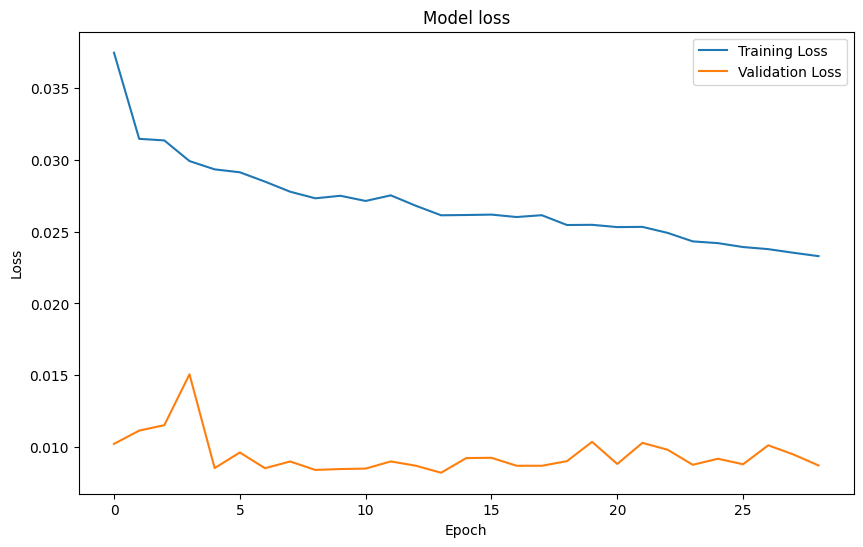

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Save the model and params

In [ ]:
# Save the model
model.save('CCS_BiLSTM.keras')
with open('model_params.pkl', 'wb') as f:
    pickle.dump({'mean': ccs_mean, 'std': ccs_std, 'scaler': scaler}, f)

In [ ]:
y_pred_test = model.predict([np.array(X_test_seq), np.array(X_test_mc)])
y_pred_test_orig = y_pred_test * ccs_std + ccs_mean
y_test_orig = y_test * ccs_std + ccs_mean

In [ ]:
df = pd.DataFrame({
    'y_test_orig': y_test_orig.flatten(),
    'y_pred_test_orig': y_pred_test_orig.flatten()
})

df.to_csv('test_and_predictions.csv', index=False)

In [17]:
r2_test = r2_score(y_test_orig , y_pred_test_orig)
print(f"Test R^2: {r2_test}")

mse_test = mean_squared_error(y_test_orig , y_pred_test_orig)
print(f"Test MSE: {mse_test}")


Test R^2: 0.9912119727373431
Test MSE: 5.855435896418454e-73


In [18]:
from sklearn.metrics import median_absolute_error

absolute_errors = np.abs(y_pred_test_orig - y_test_orig)

mae = median_absolute_error(y_test_orig, y_pred_test_orig)

mre = mae / np.median(y_test_orig)

print(f"Test MRE: {mre}")


Test MRE: 0.013205089686679864


/tmp/ipykernel_272/3158844750.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y_test_orig, y_pred_test_orig, cmap='winter', alpha=0.2)


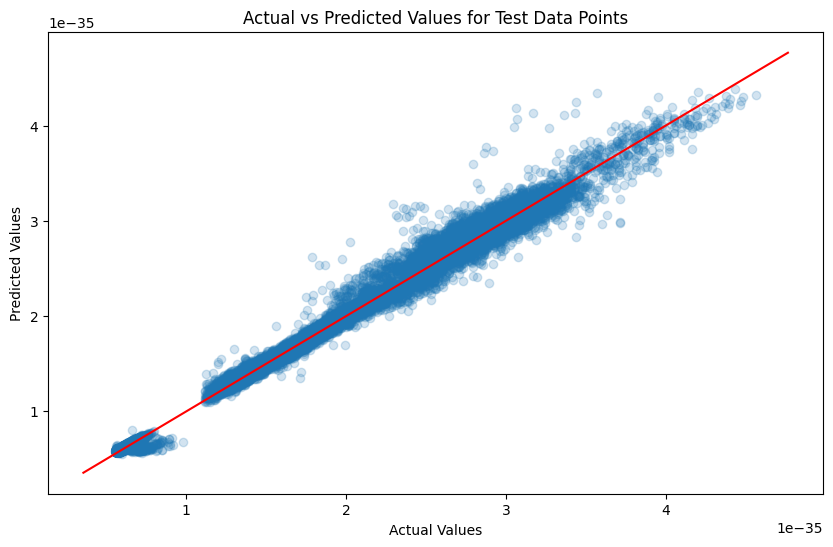

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_orig, y_pred_test_orig, cmap='winter', alpha=0.2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
limits = [np.min([plt.xlim(), plt.ylim()]),  # find the lower limit
          np.max([plt.xlim(), plt.ylim()])]  # find the upper limit
plt.plot(limits, limits, color='red')
plt.title('Actual vs Predicted Values for Test Data Points')
plt.show()

In [ ]:
# Predict in batches
y_pred_all = []
batch_size = 50000  # Adjust based on your system's memory
for i in range(0, len(one_hot_sequences), batch_size):
    y_pred_batch = model.predict([np.array(one_hot_sequences[i:i+batch_size]), np.array(mass_charge_length_scaled[i:i+batch_size])])
    y_pred_all.extend(y_pred_batch)
y_pred_all = np.array(y_pred_all)
# Reverse the z-score transformation
y_pred_all = y_pred_all * ccs_std + ccs_mean
plt.figure(figsize=(10, 6))
plt.scatter(y * ccs_std + ccs_mean, y_pred_all, cmap='winter', alpha=0.2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
limits = [np.min([plt.xlim(), plt.ylim()]),  # find the lower limit
          np.max([plt.xlim(), plt.ylim()])]  # find the upper limit
plt.plot(limits, limits, color='red')
plt.title('Actual vs Predicted Values for All Data Points')
plt.show()

In [ ]:
def predict_ccs(mass, charge, sequence):
    model = tf.keras.models.load_model('CCS_lstm_len.keras')

    with open('model_params.pkl', 'rb') as f:
        params = pickle.load(f)
    ccs_mean = params['mean']
    ccs_std = params['std']
    scaler = params['scaler']
    length = len(sequence)
    mass_charge_scaled = scaler.transform(np.array([[mass, charge, length]]))

    sequence_encoded = one_hot_encode(sequence.ljust(30, 'X'))

    ccs_z_pred = model.predict([np.array([sequence_encoded]), mass_charge_scaled])

    ccs_pred = ccs_z_pred * ccs_std + ccs_mean

    return ccs_pred[0][0]

# Test the function with some input values
mass = 4401.10689  
charge = 4   
sequence = 'AAAAAAAAAAAATGTEAGPGTAGGSENGSEVAAQPAGLSGPAEVGPGAVGER'  

predicted_ccs = predict_ccs(mass, charge, sequence)
print(f"Predicted CCS: {predicted_ccs}")
print("Actual: " + "2.65404611080076E-35")
